<a href="https://colab.research.google.com/github/aliciafmachado/texture_singan/blob/main/C%C3%B3pia_de_SinGAN_Alicia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthesis of textures from generative adversarial networks (SinGAN)

Authors: Alicia FORTES MACHADO et Raphael MENDES

This report is organized as it follows: first we go through an introduction on the matter, then we explain in details how the [SinGAN](https://arxiv.org/abs/1905.01164) and the [Patch Match](https://gfx.cs.princeton.edu/pubs/Barnes_2009_PAR/index.php) work, and how do combine them to do an analysis of the SinGAN algorithm.

Then, we show how to run the training and loading of SinGAN models with some basic examples. After this section, we show exhaustively all the experiments done and the conclusions that we obtained from them in a qualitative sense. Finally, we show quantitative results revolving around SIFID and analyzing if this metric makes sense and if it works for images of different sizes. We also propose some other metrics and some future work in the end.

The code necessary to run is contained in the zip file and also in the Github repository https://github.com/aliciafmachado/texture_singan. A README.md is added to explain how the files should be organized and how do you can recreate the experiments described.

## Introduction

The key innovation on [SinGAN: Learning a Generative Model from a Single Natural Image](https://arxiv.org/pdf/1905.01164.pdf)  is to train from a single image and generalize a GAN to different tasks in computer vision: denoising, inpainting, generation of new images from random noise, and even animation.

[expliquer un peu des autres choses qui sont là aujourdhui]



## Related Work

Here we explore some of the related work on generative models that use a single image and how they differ on the method we are exploring.

TODO: finish here

**Deep Image Prior**

Gets priors before learning to initialize the neural network

**InGAN**

GAN that creates natural texture from single image. Only shows qualitative results and doesn't use a specific metric.

## Theory

**Generative Adversarial Networks (GANs)**
 
This kind of network is capable of sampling artificial images from a latent space that is learned by adversarial training between a generative(G) and a discriminative(D) networks. The discrimitive one's objective is to distinguish real images and images sampled by the generative one, whose objective is to fool (D).

**Single Image Generative Adversarial Network (SinGAN)**

In the particular case of SinGAN, there is a sequence of  $N$ pairs $(G_i, D_i)$ of generative and discrimitave networks that uses only one image to be trained, leveraging the patches of the concerned image. 

The training process follows by sequentially training $(G_N, D_N), (G_{N-1}, D_{N-1}), \dots, (G_0, D_0)$, where $(G_i, D_i)$ is fixed during the training of each $(G_j, D_j)$ for all $j>i$.

Training $(G_i, D_i)$ requires an image $\tilde{x}_i$ generated by $G_{i-1}$ and a noise $z_i$, idependent of all others $z$, to train $G_i$. Then a downsample of factor $x_i$ of $\tilde{x}_i$  is furnished to $D_i$ that also have access to the corresponding patch at the original image and so $D_i$ can be trained.

In order to generate images from pure scratch one should start by furnishing noise to $G_N$ and this image will be sequentially pass by each $G_i$ up to $G_0$ that will output the final result. If starting at $G_i, i<N, $ then the output will have used a prior information (and noise) to be generated.





## Training of the neural network SinGAN

If you want to go straight to the results, please jump the part of loading and training models and go straight to qualitative results. Then we analyze a metric: SIFID, which adapts FID to single image usage.

### Setting up

Connecting to drive if you are using colab:

In [ ]:
# Connect to drive in to save images and etc directly there
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/MVA/ImagerieNumerique/projet'
%ls

Mounted at /content/drive
/content/drive/My Drive/MVA/ImagerieNumerique/projet
annd.txt  ann.txt  a.png  b.png  SinGAN/


Use cells below only if it's first installation.



In [ ]:
## First we clone SinGAN if necessary:
# ! git clone https://github.com/tamarott/SinGAN.git

In [ ]:
% cd SinGAN

/content/drive/My Drive/MVA/ImagerieNumerique/projet/SinGAN


In [ ]:
! python -m pip install -r requirements.txt

In [ ]:
# Downgrade torchvision version
! pip install --upgrade torchvision==0.4.0

     |████████████████████████████████| 8.8 MB 4.0 MB/s 
     |████████████████████████████████| 748.9 MB 658 bytes/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0 which is incompatible.


In [ ]:
# You should install imagemagick in your machine before proceeding
# But notice that in colab it doesn't work, so you might need to run
# patchmatch in your own machine as detailed below
! apt install imagemagick

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

### Imports

In [ ]:
import numpy as np
from skimage.util.shape import view_as_windows
from PIL import Image
import os
from matplotlib import pyplot as plt

## Auxiliary Functions

Some auxiliary functions to deal with images and change them as we need.

They were used to transform the original images in the size that we want. There is an other function that convert images from png to jpg, so that we can apply SIFID on them. An other function is the one that crops the image in the center so that we can test the capacity of SinGAN to produce texture from less data.

In [ ]:
def resize(img_path, save_path, h=600, v=None):
  im = Image.open(img_path)
  h_or, v_or = im.size
  im_r = im.resize((h, int(v_or * h / h_or)))
  im_r.save(save_path)
  print('Saved image!')

In [ ]:
def convert_to_jpg(filename, path, move_to_results=False, move_to_comp=False):
  im = Image.open(path + '/' + filename + '.png')
  rgb_im = im.convert('RGB')
  if move_to_results:
    rgb_im.save('Input/Results/' + filename + '.jpg')
  elif move_to_comp:
    rgb_im.save('Input/Comparison/' + filename + '.jpg')
  else:
    rgb_im.save(path + '/' + filename + '.jpg')

In [ ]:
def crop_img(img_path, save_path, size=0.5):
  "Crops from middle."
  im = Image.open(img_path)
  h_or, v_or = im.size
  top = v_or * (1 - size) / 2
  bottom = v_or * (1 + size) / 2
  left = h_or * (1 - size) / 2
  right = h_or * (1 + size) / 2
  im_c = im.crop((left, top, right, bottom))
  im_c.save(save_path)
  print('Cropped image!')

Some auxiliary functions for reading and treating the data saved by patchmatch:

In [ ]:
def read_patchmatch_out(path, file):
  """
  Read patchmatch output file.
  """
  with open(path, 'r') as f:
    lines = f.read().splitlines()
  l = [[int(num) for num in line.split(" ") if num] for line in lines]
  matrix = np.array(l)

  if file == 'ann':
    shp = matrix.shape
    matrix = matrix.reshape(shp[0], shp[1] // 2, 2)

  return matrix

def get_patchmatch_info(ann_pth, annd_pth):
  """
  We read the pacthmatch and returns a matrix with the mapping to
  the original image patches, and the distances matrix.
  """
  ann = read_patchmatch_out(ann_pth, file='ann')
  annd = read_patchmatch_out(annd_pth, file='annd')

  return ann, annd

In order to run patchmatch, you have to run the file pm_minimal.cpp, which is a slightly modified version (only on the part of saving the output) of the official minimal implementation of patchmatch (therefore, not totally optimized).

Notice that it's unfortunately not possible to run it on colab since Imagemagick doesn't install properly. What we did was to run patchmatch in our local machines and then upload the results back to drive.

Nevertheless, we leave the commands below, so that you can try to run it in colab.

In [ ]:
# This is how you can run the file "pm_minimal.cpp" in the zipped folder:
# If you want to compile from scratch
! g++ pm_minimal.cpp
# If you want to run the executable directly
# Remember to change the name of the inputs
%shell ./a.out fake_image.png real_image.png unnecessary_arg.png unnecessary_arg.png

Now that we have these functions in hands, we can test with images provided by the patch match author in its official implementation:

In [ ]:
ann_pth = 'ann.txt'
annd_pth = 'annd.txt'
ann, annd = get_patchmatch_info(ann_pth, annd_pth)

In [ ]:
# Test if everything is working properly:
from PIL import Image

img_or = Image.open('a.png')
img_other = Image.open('b.png')
img_or_arr = np.array(img_or)
img_other_arr = np.array(img_other)

In [ ]:
# There is a mapping from A -> B
# Thus, if we want to analyze the mapping from the fake image
# we have to first pass the fake image as first argument
# and then pass the original image as second argument
patch_or = img_or_arr[0:0+7, 0:0+7, :]
patch_other = img_other_arr[18:(18+7), 398:(398+7), :]

Let's visualize some patches:

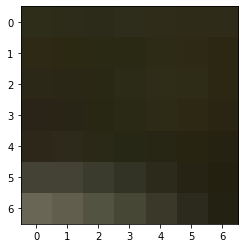

In [ ]:
plt.imshow(patch_or)
plt.show()

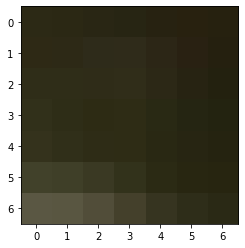

In [ ]:
plt.imshow(patch_other)
plt.show()

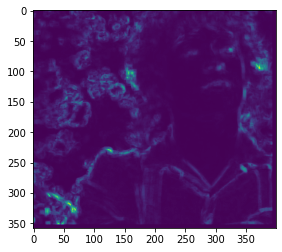

In [ ]:
plt.imshow(annd)
plt.show()

What you see above corresponds to the distances between the patches there were matched using patch match. When the colour is more intense, it means that we have larger values. Therefore, we can see that the algorithm has larger distances in patches that are in the contouring of the objects in the image.

This pattern repeats itself with our results, and it's probably due the fact that the object itself doesn't change much but the way the elements of the image are positioned changes and therefore the borders between different objects have different patterns.

## Training new models

This section is in case you want to train the models yourself, which may take a while. We just call the script from the code since we don't do any modifications on the training aspect of SinGAN.

We advise you to run the code on GPU, although it's possible to run on CPU. If running on CPU, you will need to add an extra flag '--not_cuda'.

Notice that we deleted the output since it takes too much space and makes the notebook messy.

In [ ]:
%%time
! python main_train.py --input_name rocks_small.png
! python main_train.py --input_name rocks_small_cropped.png
! python main_train.py --input_name rocks_small_1_8.png
! python main_train.py --input_name bricks.png
! python main_train.py --input_name bricks_0_5.png
! python main_train.py --input_name saumon.png
! python main_train.py --input_name leafs_small.png
! python main_train.py --input_name leafs_small_cropped.png
! python main_train.py --input_name leafs_small_1_8.png
! python main_train.py --input_name bronze_texture.png
! python main_train.py --input_name golden_texture.jpg
! python main_train.py --input_name beach_scene.jpg

## Load trained models and test them

We directly run the scripts for the tasks described in the paper, which are provided by the author of SinGAN as you can see below.

If you want to test our models and not train them, we provide some of them on the Github repository which can be downloaded in https://github.com/aliciafmachado/texture_singan.

This part is focused on loading the models and getting results for different generate scales and sizes. In the next sections, we discuss results and evaluate the proposed metric SIFID. 

The images used for both evaluation and training are provided in the same repository referred above.

Generation for "rocks_small.png", "rocks_small_cropped.png", "rocks_small_1_8.png", "", "" and "" images:

In [ ]:
%%time
# rocks_small.png
! python random_samples.py --input_name rocks_small.png --mode random_samples --gen_start_scale 0

# rocks_small_cropped.png
! python random_samples.py --input_name rocks_small_cropped.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 2 --scale_v 2

# rocks_small_1_8.png
! python random_samples.py --input_name rocks_small_1_8.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 4 --scale_v 4

#
! python random_samples.py --input_name saumon.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 4 --scale_v 1

#

Generation for '', '' and '' images:

In [ ]:
%%time
#
! python random_samples.py --input_name saumon.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 4 --scale_v 1

Random Seed:  4504


Generation for '', '' and '' images:

In [ ]:
%%time

! python random_samples.py --input_name saumon.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 1 --scale_v 4

Random Seed:  9949


Generation for '', '' and '' images:

In [ ]:
%%time

!

## Generating random samples

In [ ]:
## On fait des testes
! python random_samples.py --input_name bricks_0_5.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 2 --scale_v 2

Random Seed:  6369


## Qualitative Results

We test on different textures that have particular structures and show how the neural networks performs badly / well.

We will focus on trying different approaches in terms of size of the image.

Notice that we checked that SinGAN worked properly with some of the images provided by the author, but we decide to focus on other textures, so that we could see if SinGAN would work for these as well.

### Rocks texture

Original image, $\frac{1}{4}$ of the image and $\frac{1}{16}$. Notice that we took these parts of the image from the middle of the original one.

The idea behind learning on smaller images was that the rocks follow the same pattern throughout the image. So the idea here is that the model might be able to learn with less data to recreate the same texture, and therefore use less computational ressources.

In [3]:
def plot_imgs(list_paths, list_titles, main_title, figsize=(15,3.5), nb_plots=3):
  fig, axs = plt.subplots(1, nb_plots, figsize=figsize)
  fig.suptitle(main_title)

  if nb_plots == 1:
    axs.set_axis_off()
    axs = [axs]
  else:
    [axi.set_axis_off() for axi in axs.ravel()]
  for i in range(len(axs)):
    axs[i].imshow(Image.open(list_paths[i]))
    axs[i].title.set_text(list_titles[i])

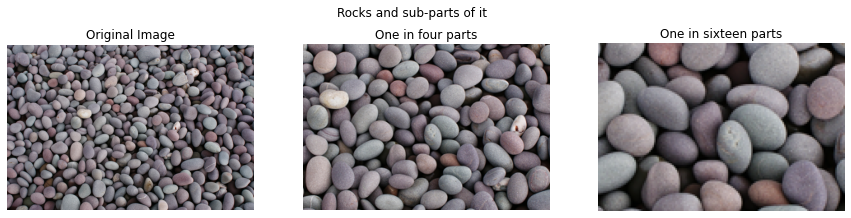

In [ ]:
list_paths = ['Input/Images/rocks_small.png', 
              'Input/Images/rocks_small_cropped.png',
              'Input/Images/rocks_small_1_8.png']
list_titles = ['Original Image',
               'One in four parts',
               'One in sixteen parts']

main_title = 'Rocks and sub-parts of it'

plot_imgs(list_paths, list_titles, main_title)

Now we show our results when using the original image and the other two to generate samples of the same size as the original image:

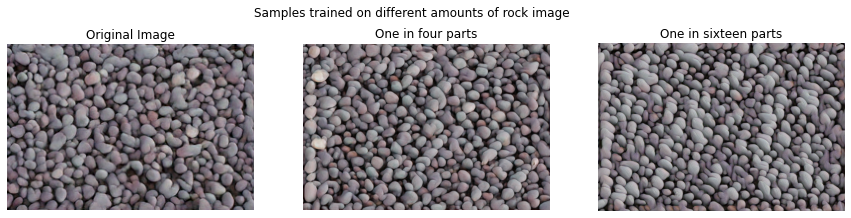

In [ ]:
list_paths = ['Output/RandomSamples/rocks_small/gen_start_scale=0/0.png',
              'Output/RandomSamples_ArbitrerySizes/rocks_small_cropped/scale_v=2.000000_scale_h=2.000000/0.png',
              'Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v=4.000000_scale_h=4.000000/0.png']

main_title = 'Samples trained on different amounts of rock image'

plot_imgs(list_paths, list_titles, main_title)

Results show that the algorithm is capable to generalize, but as we decrease the size of the image, we have worse results in terms of variability, which is expected. However, for an untrained eye, results when training on the original image and when training with one fourth of the original image are similar, which might indicate that indeed we can reproduce good results with less.

One issue is that, as you can see above, we have artifacts in the border of the image that worsen as we reduce the size of the image.

### Saumon texture

We chose to analyze this image as we wanted to see if SinGAN was able to keep the structure of the saumon texture. We searched here to see if the neural network would be able to extend the texture in the horizontal and in the vertical properly.

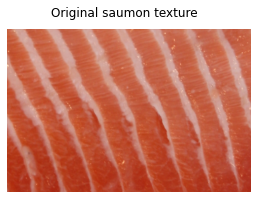

In [ ]:
list_paths = ['Input/Images/saumon.png']
list_titles = ['']

main_title = 'Original saumon texture'

plot_imgs(list_paths, list_titles, main_title, nb_plots=1, figsize=(5,3))

When expanding the saumon texture in the horizontal, we can see that the stripes are almost correctly expanded on the horizontal, and that there are very few stripes that are broken in the middle or that bifurcate.

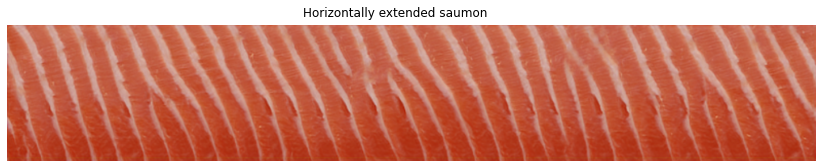

In [ ]:
list_paths = ['Output/RandomSamples_ArbitrerySizes/saumon/scale_v=1.000000_scale_h=4.000000/0.png']
list_titles = ['']

main_title = 'Horizontally extended saumon'

plot_imgs(list_paths, list_titles, main_title, nb_plots=1, figsize=(18,2.5))

However, when expanding it on the vertical, we can see more inconsistencies than when extending horizontally.

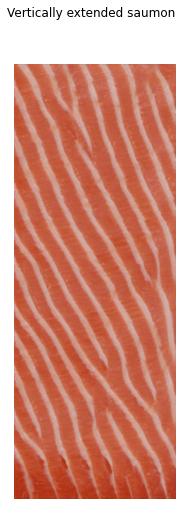

In [ ]:
list_paths = ['Output/RandomSamples_ArbitrerySizes/saumon/scale_v=4.000000_scale_h=1.000000/0.png']
list_titles = ['']

main_title = 'Vertically extended saumon'

plot_imgs(list_paths, list_titles, main_title, nb_plots=1, figsize=(4,8))

### Bricks texture

Another object that we wanted to check if could keep the structure was bricks.

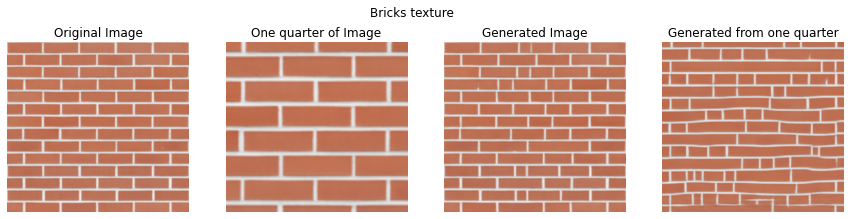

In [ ]:
list_paths = ['Input/Images/bricks.png',
              'Input/Images/bricks_0_5.png',
              'Output/RandomSamples/bricks/gen_start_scale=0/0.png',
              'Output/RandomSamples_ArbitrerySizes/bricks_0_5/scale_v=2.000000_scale_h=2.000000/0.png']
list_titles = ['Original Image',
               'One quarter of Image',
               'Generated Image',
               'Generated from one quarter']

main_title = 'Bricks texture'

plot_imgs(list_paths, list_titles, main_title, nb_plots=4)

This is an interesting result: the SinGAN is able to keep the lines straight and the correct heights on the example generated from the original image, but isn't able to keep the horizontal sizes constants. With respect to the image generated from one quarter of the original image, we can see that the quality decays a lot: we don't have straight lines anymore and artifacts appear in the bottom of the image. This might be explained by the fact that we are trained less parameters, since the way SinGAN is implemented, our number of generators / discriminators is determinated by the size of the image used for training. 

### Leafs texture

Here, we wanted to try with a more natural image: leafs. We repeat the same experiments on the original image and smaller parts of it. However, in this case, results degrade much more quickly due to the fact that smaller parts of the image doesn't have the patterns present in the whole image.

Images and parts of it:

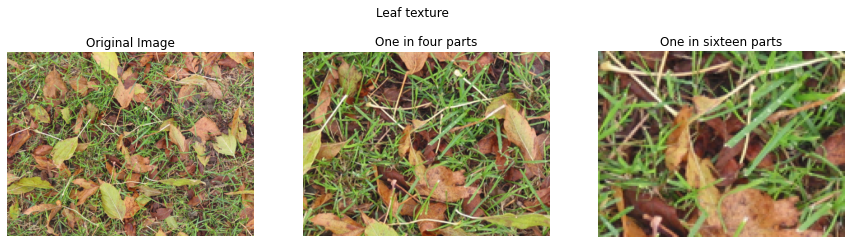

In [ ]:
list_paths = ['Input/Images/leafs_small.png',
              'Input/Images/leafs_small_cropped.png',
              'Input/Images/leafs_small_1_8.png']
list_titles = ['Original Image',
               'One in four parts',
               'One in sixteen parts']

main_title = 'Leaf texture'

plot_imgs(list_paths, list_titles, main_title, figsize=(15,4))

Generated images:

In [ ]:
! python random_samples.py --input_name leafs_small.png --mode random_samples --gen_start_scale 0
! python random_samples.py --input_name leafs_small_cropped.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 2 --scale_v 2
! python random_samples.py --input_name leafs_small_1_8.png --mode random_samples_arbitrary_sizes --gen_start_scale 0 --scale_h 4 --scale_v 4

Random Seed:  7680
Random Seed:  4577
Random Seed:  1965


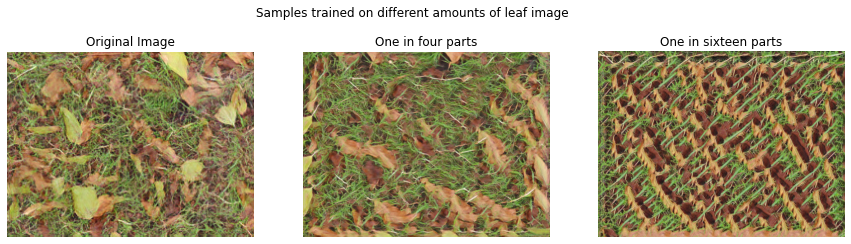

In [ ]:
list_paths = ['Output/RandomSamples/leafs_small/gen_start_scale=0/0.png',
              'Output/RandomSamples_ArbitrerySizes/leafs_small_cropped/scale_v=2.000000_scale_h=2.000000/0.png',
              'Output/RandomSamples_ArbitrerySizes/leafs_small_1_8/scale_v=4.000000_scale_h=4.000000/0.png']

main_title = 'Samples trained on different amounts of leaf image'

plot_imgs(list_paths, list_titles, main_title, figsize=(15,4))

### Transfer texture

The capacity of the SinGAN to operate transfer texture, is tested by two experiments based on similar tasks which is to generate, from an image of a concrete statue with a porous texture (Christ the Redeemer with cloudy sky behind), an image of the same statue but with metallic textures. The first experiment uses paint to image functionality and the second uses harmonization.

#### Paint to Image

The model used here is trained over an similar image but with a golden statue (with a different cloudy sky behind), and then "paint to image" functionnality is applied to the Christ the Redeemer entire image. The best scale injection preserves shape and details of the original statue but the texture was not the desire over all the statue.


In [ ]:
! python paint2image.py --input_name golden_texture.jpg --ref_name cristo.jpg --paint_start_scale 1
! python paint2image.py --input_name golden_texture.jpg --ref_name cristo.jpg --paint_start_scale 2
! python paint2image.py --input_name golden_texture.jpg --ref_name cristo.jpg --paint_start_scale 3
! python paint2image.py --input_name golden_texture.jpg --ref_name cristo.jpg --paint_start_scale 4
! python paint2image.py --input_name golden_texture.jpg --ref_name cristo.jpg --paint_start_scale 5
! python paint2image.py --input_name golden_texture.jpg --ref_name cristo.jpg --paint_start_scale 6
! python paint2image.py --input_name golden_texture.jpg --ref_name cristo.jpg --paint_start_scale 7
! python paint2image.py --input_name golden_texture.jpg --ref_name cristo.jpg --paint_start_scale 8

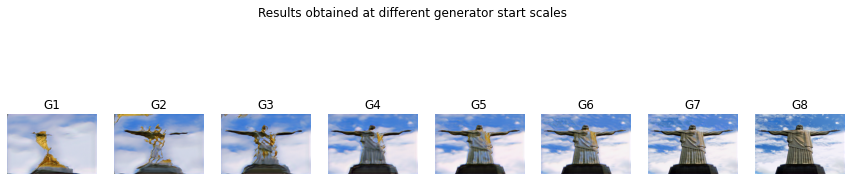

In [12]:
list_paths = ['Output/Paint2image/golden_texture/cristo_out/start_scale=1.png',
              'Output/Paint2image/golden_texture/cristo_out/start_scale=2.png',
              'Output/Paint2image/golden_texture/cristo_out/start_scale=3.png',
              'Output/Paint2image/golden_texture/cristo_out/start_scale=4.png',
              'Output/Paint2image/golden_texture/cristo_out/start_scale=5.png',
              'Output/Paint2image/golden_texture/cristo_out/start_scale=6.png',
              'Output/Paint2image/golden_texture/cristo_out/start_scale=7.png',
              'Output/Paint2image/golden_texture/cristo_out/start_scale=8.png']

main_title = 'Results obtained at different generator start scales'

list_titles=[f"G{i}" for i in range(1,9)]

plot_imgs(list_paths, list_titles, main_title, figsize=(15,4), nb_plots=8)

#### Harmonization

The model used here is trained over an image that contains purely a bronze texture and then the harmonization is applied to an image which is the superposition of Christ the Redeemer and the original bronze_texture. Results show that statue details are not preserved when using coarsest injection scale and no texture is applied for higher injection scales.

Mask used fro this photo was already given.

    

In [13]:
! python harmonization.py --input_name bronze_texture.png --ref_name christ_superposition_texture.jpg --harmonization_start_scale 1
! python harmonization.py --input_name bronze_texture.png --ref_name christ_superposition_texture.jpg --harmonization_start_scale 2
! python harmonization.py --input_name bronze_texture.png --ref_name christ_superposition_texture.jpg --harmonization_start_scale 3
! python harmonization.py --input_name bronze_texture.png --ref_name christ_superposition_texture.jpg --harmonization_start_scale 4
! python harmonization.py --input_name bronze_texture.png --ref_name christ_superposition_texture.jpg --harmonization_start_scale 5
! python harmonization.py --input_name bronze_texture.png --ref_name christ_superposition_texture.jpg --harmonization_start_scale 6
! python harmonization.py --input_name bronze_texture.png --ref_name christ_superposition_texture.jpg --harmonization_start_scale 7
! python harmonization.py --input_name bronze_texture.png --ref_name christ_superposition_texture.jpg --harmonization_start_scale 8

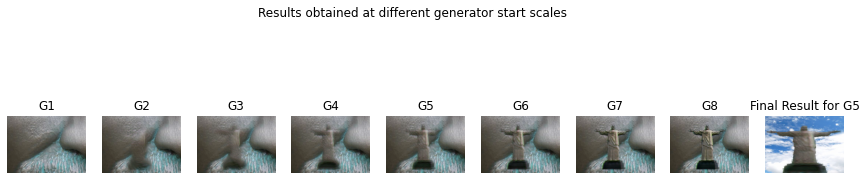

In [24]:
list_paths = ['Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=1.png',
              'Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=2.png',
              'Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=3.png',
              'Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=4.png',
              'Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=5.png',
              'Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=6.png',
              'Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=7.png',
              'Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=8.png',
              'Output/Harmonization/bronze_texture/christ_superposition_texture_out/bronze_christ.jpg']

main_title = 'Results obtained at different generator start scales'

list_titles=[f"G{i}" for i in range(1,9)]
list_titles.append("Final Result for G5")

plot_imgs(list_paths, list_titles, main_title, figsize=(15,4), nb_plots=9)

### Observing SinGAN texture behavior on editing task

In this experiment, model is trained on a beach scene with some people at first and second plan and the same is done over some clouds. Some patches with no people are copied and pasted over people on second plan. We observe that the distribution of the training image prevails over the input image for coarser generator start scales, creating people on edited patches.

In [ ]:
! python editing.py --input_name beach_scene.jpg --ref_name beach_scene_translating.jpg --editing_start_scale 1
! python editing.py --input_name beach_scene.jpg --ref_name beach_scene_translating.jpg --editing_start_scale 2
! python editing.py --input_name beach_scene.jpg --ref_name beach_scene_translating.jpg --editing_start_scale 3
! python editing.py --input_name beach_scene.jpg --ref_name beach_scene_translating.jpg --editing_start_scale 4
! python editing.py --input_name beach_scene.jpg --ref_name beach_scene_translating.jpg --editing_start_scale 5
! python editing.py --input_name beach_scene.jpg --ref_name beach_scene_translating.jpg --editing_start_scale 6
! python editing.py --input_name beach_scene.jpg --ref_name beach_scene_translating.jpg --editing_start_scale 7
! python editing.py --input_name beach_scene.jpg --ref_name beach_scene_translating.jpg --editing_start_scale 8

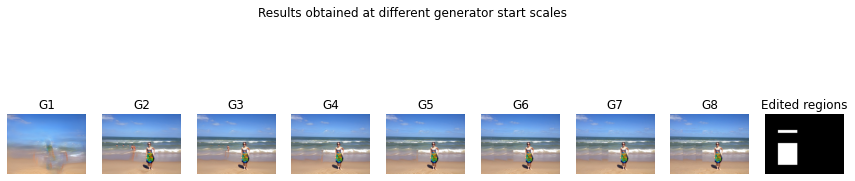

In [26]:
list_paths = ['Output/Editing/beach_scene/beach_scene_translating_out/start_scale=1.png',
              'Output/Editing/beach_scene/beach_scene_translating_out/start_scale=2.png',
              'Output/Editing/beach_scene/beach_scene_translating_out/start_scale=3.png',
              'Output/Editing/beach_scene/beach_scene_translating_out/start_scale=4.png',
              'Output/Editing/beach_scene/beach_scene_translating_out/start_scale=5.png',
              'Output/Editing/beach_scene/beach_scene_translating_out/start_scale=6.png',
              'Output/Editing/beach_scene/beach_scene_translating_out/start_scale=7.png',
              'Output/Editing/beach_scene/beach_scene_translating_out/start_scale=8.png',
              'Input/Editing/beach_scene_translating_mask.jpg']

main_title = 'Results obtained at different generator start scales'

list_titles=[f"G{i}" for i in range(1,9)]
list_titles.append("Edited regions")

plot_imgs(list_paths, list_titles, main_title, figsize=(15,4), nb_plots=9)

## Calculate metrics

We need to convert to JPG so that SIFID works.

In [ ]:
! rm Input/Results/rocks_small_1_8.jpg

In [ ]:
filename = 'rocks_small_1_8'
path = "Input/Images"
convert_to_jpg(filename, path, move_to_results=True)

In [ ]:
filename = '0'
path = 'Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v=4.000000_scale_h=4.000000'
convert_to_jpg(filename, path)

In [ ]:
# Remove so that we calculate the SIFID for correct image
! rm Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v=1.000000_scale_h=1.000000/0.jpg

The path is to the folder and not the file.



In [ ]:
%%time
# CAUTION: coment lines 245 and 246 in sifid_score.py to work
# Before running this cell, it's necessary to coment lines 245 and 246 in the code
# Since it requires the last characters of the image to be an integer number
! python SIFID/sifid_score.py --path2real Input/Results --path2fake Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v\=4.000000_scale_h\=4.000000

This results is correspondent to the ones reported in the paper. Now let's check for larger outputs.

Then, we compare the 4 times increased to the original image.

In [ ]:
%%time
# Evaluate when we want to increase the size of the image 4 times
# horizontally and vertically
! python SIFID/sifid_score.py --path2real Input/Results --path2fake Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v\=4.000000_scale_h\=4.000000

100% 1/1 [00:00<00:00, 82.29it/s]
100% 1/1 [00:00<00:00,  8.48it/s]
SIFID:  0.74693894
CPU times: user 1 s, sys: 145 ms, total: 1.15 s
Wall time: 3min 41s


In [ ]:
! rm Input/Results/rocks_small_1_8.jpg
convert_to_jpg('rocks_small', 'Input/Images', move_to_results=True)

In [ ]:
%%time
# Evaluate with respect to original image
! python SIFID/sifid_score.py --path2real Input/Results --path2fake Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v\=4.000000_scale_h\=4.000000

100% 1/1 [00:00<00:00, 11.92it/s]
100% 1/1 [00:00<00:00,  9.40it/s]
SIFID:  0.2079012
CPU times: user 919 ms, sys: 133 ms, total: 1.05 s
Wall time: 3min 29s


In [ ]:
convert_to_jpg('rocks_small_1_8', 'Input/Images', move_to_comp=True)

In [ ]:
%%time
# Evaluate patch removed from original image w.r.t. to the one created
! python SIFID/sifid_score.py --path2real Input/Results --path2fake Input/Comparison

100% 1/1 [00:00<00:00, 11.77it/s]
100% 1/1 [00:00<00:00, 103.49it/s]
SIFID:  0.64149064
CPU times: user 926 ms, sys: 131 ms, total: 1.06 s
Wall time: 3min 33s


In [ ]:
# Analyze statistics: distribution...
# TODO: choose statistics and write here
# TODO: implement statistics

In [ ]:
! zip -r TrainedModels_w_smaller_rock.zip TrainedModels
# ! zip -r Output_smaller.zip Output
from google.colab import files
files.download('TrainedModels_w_smaller_rock.zip')
# files.download('Output_rock.zip')

In [ ]:
! python main_train.py --input_name leafs_small.png

In [ ]:
! zip -r TrainedModels_leafs.zip TrainedModels
from google.colab import files
files.download('TrainedModels_leafs.zip')

## Metrics

We decided to analyze the new metric SIFID:

First, we realized that even though we achieve results as the ones reported in the paper, comparing a sample of very different size w.r.t. original image caused SIFID to increase as we can see in the example below:

Then, we decided to do an experiment to check the capacity of SIFID to analyze images of different sizes:

As you can see, SIFID is smaller when we compare to the original image than when we compare with the actual image it was trained to reproduce. Therefore, there is an issue on using this metric for images of different sizes.

Because of that, we decided to try an approach to fix the problem:

1. Use SIFID on the fake patches and nearest neighbors on the original image, by using patchmatch. For this one, we start with a naive approach of dividing the image in patches of the same size as the original image and then taking the mean of the SIFID scores calculated of each patch and the original image.

<!-- 2. Use FID by taking the patches of the original image as dataset and the patches of new image as generated samples. -->

Notice that all of our tests are done on the rocks texture.

First, we start with the first approach, which is implemented and then tested below:

In [ ]:
# Here we implement the auxiliary function to create the patches and save
# them into a folder
def save_patches(img_pth, img_name, save_pth, patch_div=None, 
                 method='naive', patchmatch=None, size_patch=None, 
                 img_or_pth=None, save_img_or=None):
  # First, we take the patches
  # Read images
  # TODO: modify sifid_score.py in the import and in the lines cited below
  # so that we don't have to do it everytime (import in line 41 becomes 
  # from SIFID.inception)
  print('First we clean up Comparison and Results folder.')

  if save_img_or:
    for f in os.listdir(save_img_or):
      os.remove(os.path.join(save_img_or, f))

  for f in os.listdir(save_pth):
    os.remove(os.path.join(save_pth, f))

  print('Beginning creation of patches')
  img = Image.open(img_pth)
  img_np = np.array(img)
  h, v = img.size
  if method == 'naive':
    window_shape = (v // patch_div, h // patch_div, 3)
    img_patches = view_as_windows(img_np, window_shape)

    for i in range(patch_div):
      for j in range(patch_div):
        img_patch = Image.fromarray(img_patches[i * window_shape[0],
                                                j * window_shape[1],
                                                0])
        img_patch.save(save_pth + '/'+ img_name + 
                      '_patch_' + str(i) + '_' + str(j) + '.jpg')
  else:
    img_or = Image.open(img_or_pth)
    img_or_np = np.array(img_or)

    h, v, _ = patchmatch.shape
    name_file = '0'
    for i in range(h):
      for j in range(v):
        img_patch = Image.fromarray(img_np[i:(i+size_patch),
                                           j:(j + size_patch),
                                           0])
        img_patch.save(save_pth + '/'+ img_name + 
                      '_patch_' + str(i) + '_' + str(j) + '.jpg')
        real_patch = Image.fromarray(img_or_np[patchmatch[i,j,0]:(patchmatch[i,j,0]+size_patch),
                                                patchmatch[i,j,1]:(patchmatch[i,j,1]+size_patch)])
        img_patch.save(save_img_or + '/'+ img_name + 
                      '_patch_' + str(i) + '_' + str(j) + '.jpg')

  print('Finished!')

In [ ]:
# Naive approach
save_patches(img_pth='Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v=4.000000_scale_h=4.000000/0.jpg', 
             img_name='rocks_small_1_8_scale_v=4.000000_scale_h=4.000000_0.jpg',
             save_pth='Input/Results',
             patch_div=4)

We use results of patchmatch computed in local machines and then uploaded back to drive. We create a folder called "ann" and put the outputs we are using there.

In [ ]:
ann, annd = get_patchmatch_info(ann_pth='ann/ann.txt', annd_pth='ann/annd.txt')

# Patchmatch approach
save_patches(img_pth='Output/RandomSamples_ArbitrerySizes/rocks_small_1_8/scale_v=4.000000_scale_h=4.000000/0.jpg', 
             img_name='rocks_small_1_8_scale_v=4.000000_scale_h=4.000000_0.jpg',
             save_pth='Input/Results',
             method='patchmatch', patchmatch=ann, size_patch=11,
             img_or_pth='Input/Images/rocks_small.png', 
             save_img_or='Input/Comparison')

First we clean up Comparison and Results folder.
Beginning creation of patches
Finished!


In [ ]:
ann, annd = get_patchmatch_info(ann_pth='ann/ann.txt', annd_pth='ann/annd.txt')


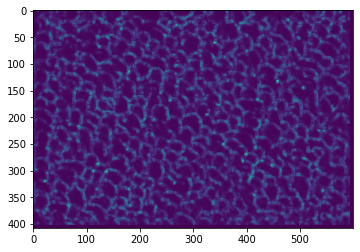

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(annd)
plt.show()

### TODO

In [ ]:
from SIFID.sifid_score import *
from SIFID.inception import InceptionV3


def calculate_sifid_given_paths_mult(path1, path2, batch_size, cuda, dims,
                                    suffix, mult_patch_approach):
  """Calculates the SIFID of two paths"""

  block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

  model = InceptionV3([block_idx])
  if cuda:
      model.cuda()

  path1 = pathlib.Path(path1)
  files1 = sorted(list(path1.glob('*.%s' %suffix)))

  path2 = pathlib.Path(path2)
  files2 = sorted(list(path2.glob('*.%s' %suffix)))

  # If we use the naive approach, then we repeat the file
  # for the number of patches saved in the folder
  if mult_patch_approach == 'naive':
    files1 = len(files2) * files1

  fid_values = []
  Im_ind = []

  if mult_patch_approach == 'naive':
    for i in range(len(files2)):
        m1, s1 = calculate_activation_statistics([files1[i]], model, batch_size, dims, cuda)
        print(m1, s1)
        m2, s2 = calculate_activation_statistics([files2[i]], model, batch_size, dims, cuda)
        print(m2, s2)
        fid_values.append(calculate_frechet_distance(m1, s1, m2, s2))
        file_num1 = files1[i].name
        file_num2 = files2[i].name
  else:
    for i in range(len(files2)):
        m1, s1 = calculate_activation_statistics_patch([files1[i]], model, batch_size, dims, cuda)
        print(m1, s1)
        m2, s2 = calculate_activation_statistics_patch([files2[i]], model, batch_size, dims, cuda)
        print(m2, s2)
        fid_values.append(calculate_frechet_distance(m1, s1, m2, s2))
        file_num1 = files1[i].name
        file_num2 = files2[i].name

  return fid_values


# We reiplement SIFID here so that we take the mean between
# the patches on the image created
def main_sifid_multiple_patches(path2real, path2fake, suffix, gpu, 
                                mult_patch_approach= 'naive'):
  """
  We save the patches and then use them, which might not be
  very efficient but works properly.
  """
  sifid_values = calculate_sifid_given_paths_mult(path2real, path2fake, 
                                                  1, gpu,
                                                  64, suffix, 
                                                  mult_patch_approach)
  sifid_values = np.asarray(sifid_values,dtype=np.float32)
  np.save('SIFID', sifid_values)
  print('SIFID: ', sifid_values.mean())
  return sifid_values

def calculate_activation_statistics_patch(files, model, batch_size=1,
                                    dims=64, cuda=False, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : The images numpy array is split into batches with
                     batch size batch_size. A reasonable batch size
                     depends on the hardware.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the
                     number of calculated batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the inception model.
    -- sigma : The covariance matrix of the activations of the inception model.
    """
    act = get_activations(files, model, batch_size, dims, cuda, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma


def get_activations_patch(files, model, batch_size=1, dims=64,
                    cuda=False, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.
    Params:
    -- files       : List of image files paths
    -- model       : Instance of inception model
    -- batch_size  : Batch size of images for the model to process at once.
                     Make sure that the number of samples is a multiple of
                     the batch size, otherwise some samples are ignored. This
                     behavior is retained to match the original FID score
                     implementation.
    -- dims        : Dimensionality of features returned by Inception
    -- cuda        : If set to True, use GPU
    -- verbose     : If set to True and parameter out_step is given, the number
                     of calculated batches is reported.
    Returns:
    -- A numpy array of dimension (num images, dims) that contains the
       activations of the given tensor when feeding inception with the
       query tensor.
    """
    model.eval()

    if len(files) % batch_size != 0:
        print(('Warning: number of images is not a multiple of the '
               'batch size. Some samples are going to be ignored.'))
    if batch_size > len(files):
        print(('Warning: batch size is bigger than the data size. '
               'Setting batch size to data size'))
        batch_size = len(files)

    n_batches = len(files) // batch_size
    n_used_imgs = n_batches * batch_size

    pred_arr = np.empty((n_used_imgs, dims))

    for i in tqdm(range(n_batches)):
        if verbose:
            print('\rPropagating batch %d/%d' % (i + 1, n_batches),
                  end='', flush=True)
        start = i * batch_size
        end = start + batch_size

        images = np.array([imread(str(f)).astype(np.float32)
                           for f in files[start:end]])

        images = images[:,:,:,0:3]
        # Reshape to (n_images, 3, height, width)
        images = images.transpose((0, 3, 1, 2))
        #images = images[0,:,:,:]
        images /= 255

        batch = torch.from_numpy(images).type(torch.FloatTensor)
        if cuda:
            batch = batch.cuda()

        pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.

        #if pred.shape[2] != 1 or pred.shape[3] != 1:
        #    pred = adaptive_avg_pool2d(pred, output_size=(1, 1))


        pred_arr = pred.cpu().data.numpy().transpose(0, 2, 3, 1).reshape(batch_size*pred.shape[2]*pred.shape[3],-1)


    if verbose:
        print(' done')

    return pred_arr

In [ ]:
from SIFID.sifid_score import *
from SIFID.inception import InceptionV3


def calculate_sifid_given_paths_mult(path1, path2, batch_size, cuda, dims,
                                    suffix, mult_patch_approach):
  """Calculates the SIFID of two paths"""

  block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

  model = InceptionV3([block_idx])
  if cuda:
      model.cuda()

  path1 = pathlib.Path(path1)
  files1 = sorted(list(path1.glob('*.%s' %suffix)))

  path2 = pathlib.Path(path2)
  files2 = sorted(list(path2.glob('*.%s' %suffix)))

  # If we use the naive approach, then we repeat the file
  # for the number of patches saved in the folder
  if mult_patch_approach == 'naive':
    files1 = len(files2) * files1

  fid_values = []
  Im_ind = []

  for i in range(len(files2)):
      m1, s1 = calculate_activation_statistics([files1[i]], model, batch_size, dims, cuda)
      print(m1, s1)
      m2, s2 = calculate_activation_statistics([files2[i]], model, batch_size, dims, cuda)
      print(m2, s2)
      fid_values.append(calculate_frechet_distance(m1, s1, m2, s2))
      file_num1 = files1[i].name
      file_num2 = files2[i].name

  return fid_values


# We reiplement SIFID here so that we take the mean between
# the patches on the image created
def main_sifid_multiple_patches(path2real, path2fake, suffix, gpu, 
                                mult_patch_approach= 'naive'):
  """
  We save the patches and then use them, which might not be
  very efficient but works properly.
  """
  sifid_values = calculate_sifid_given_paths_mult(path2real, path2fake, 
                                                  1, gpu,
                                                  64, suffix, 
                                                  mult_patch_approach)
  sifid_values = np.asarray(sifid_values,dtype=np.float32)
  np.save('SIFID', sifid_values)
  print('SIFID: ', sifid_values.mean())
  return sifid_values


In [ ]:
sifid_values = main_sifid_multiple_patches(path2real='Input/Comparison',
                                           path2fake='Input/Results',
                                           suffix='jpg',
                                           gpu=True,
                                           mult_patch_approach='naive')

In [ ]:
sifid_values = main_sifid_multiple_patches(path2real='Input/Comparison',
                                           path2fake='Input/Results',
                                           suffix='jpg',
                                           gpu=True,
                                           mult_patch_approach='patch_match')

0.28377065


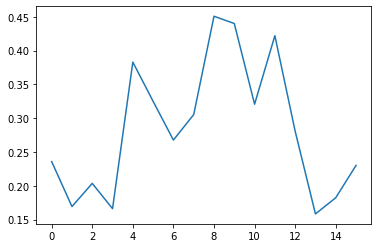

0.09665579


In [ ]:
from matplotlib import pyplot as plt

print(np.mean(sifid_values))
plt.plot(sifid_values)
plt.show()
print(np.std(sifid_values))

## Robustness

We try to change the scaling factor and alpha to see how these parameters impact in the quality of the model.

1. Scaling factor: This parameter corresponds to ... TODO. We try with 5 different values on the rock image: 0.60, 0.70, 0.75 (default), 0.80, 0.90.

2. Alpha: This parameters corresponds to ... TODO


In [ ]:
# Varying scale factor
# 0.60, 0.70, 0.75, 0.80, 0.90
%%time
! python main_train.py --input_name rocks_small.png --scale_factor 0.60
! python main_train.py --input_name rocks_small.png --scale_factor 0.70
! python main_train.py --input_name rocks_small.png --scale_factor 0.80
! python main_train.py --input_name rocks_small.png --scale_factor 0.90

In [ ]:
# Varying alpha
! python main_train.py --input_name rocks_small.png --alpha 6 # TODO: took 48 min
! python main_train.py --input_name rocks_small.png --alpha 8
! python main_train.py --input_name rocks_small.png --alpha 12
! python main_train.py --input_name rocks_small.png --alpha 14

## Future work

### Transfer Learning

According to [Transferring GANs: generating images from
limited data](https://openaccess.thecvf.com/content_ECCV_2018/papers/yaxing_wang_Transferring_GANs_generating_ECCV_2018_paper.pdf), it's possible to do transfer learning on GANs, and therefore we do a try, in order to make learning faster for a new image considering that we have a trained neural network on a similar image.

We decided to focus on a single pair of images: the original rocks and a new image of rocks, and we want to generate a new image of rocks using less ressources, since it takes very long to train on a single image.

### Speeding-up the code by optimizing it

Notice that it takes a considerable amount of time to train SinGAN on a regular image: 40 minutes for an image of size 600 x 450, even when using GPU, while running Patch Match for reshuffling can be used interactively. Therefore, we wonder that one way to approach such an issue is to optimize the code, and tune hyperparameters to reduce training time but still keep the desired quality.

This idea is inspired by the fact that the Patch Match is built on top of previous algorithms but optimizes the bottleneck of process which is finding a near neighbor.

## Conclusion

After this work, we conclude that SinGAN indeed is capable of do what it claims to do. Although, we can see that it takes enough time to train so that it can't possibly be interactive, so it's still not competitive with such a method as Patch Match, at least for the task they approach in common.

More specifically in the sense of texture generation, SinGAN is able to create new and original images, which is not the case for Patch Match, since it simply copies patches around to obtain the desired effects. Other than that, the SinGAN approach is able to learn by itself from nothing.

Therefore, we conclude that we were able to evaluate SinGAN, find some limitations, including on the metric defined by the authors. We are also able to use patchmatch to design a possible metric that might be a solution to the problem on the SIFID by itself. Other usage of patchmatch is to calculate the matching of the generated image patches to the original image ones, which makes it possible to analyze the distance to such patches and to check which patches are most used from the original image. Other than that, we explore the robustness of SinGAN with respect to two parameters: scale factor and alpha.

TODO: conclude on the robustness topic and expand the conclusion

## Appendix

Here we add some functions used for editing the images for some tasks.

These functions are specific for the case that we worked with and are added for reproducibility purposes.

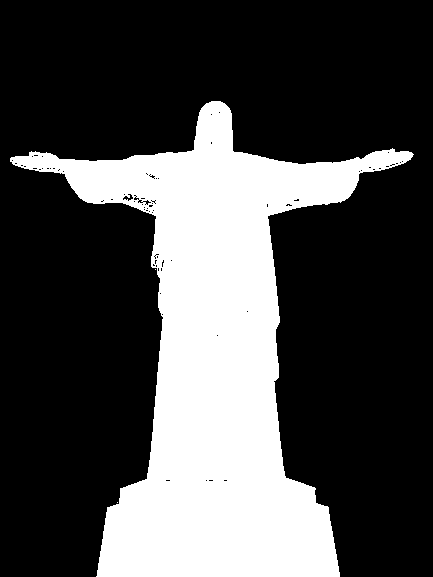

In [27]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

img = cv2.imread('Input/Images/cristo_png.png') 
np_img = np.array(img)
np_img = (np_img>0)*1*255

h, l, _ = np_img.shape
for i in range(h):
    for j in range(l):
        if not np.all(np_img[i, j, :] == [0.,0.,0.]):
            np_img[i, j, :] = [255., 255., 255.]
cv2_imshow(np_img)

In [ ]:
## Christ harmonization

texture = cv2.imread("Input/Images/bronze_texture.png")
christ = cv2.imread("Input/Images/cristo_png.png")

christ_mask = cv2.imread("Input/Images/cristo_mascara.jpg")
h, l, c = christ_mask.shape


darkboard = np.zeros(texture.shape)
darkboard[:h, 190:l+190, :c] = christ_mask

christ_mask = darkboard
christ_mask = np.where(christ_mask==0, 1., 0)

input = christ_mask*texture
input[:h, 190:l+190, :c] += christ

In [ ]:
## creates output for harmonization and generator start scales
outputchrist = cv2.imread("Output/Harmonization/bronze_texture/christ_superposition_texture_out/start_scale=5.png")
outputchrist_scaled = cv2.resize(outputchrist, (christ_mask.shape[1], christ_mask.shape[0]))
bronze_christ = (1-christ_mask)*outputchrist_scaled

christ = cv2.resize(cv2.imread("Input/Images/cristo.jpg"), (l,h))
christ = christ*christ_mask[:h, 190:l+190, :c] + bronze_christ[:h, 190:l+190, :c]

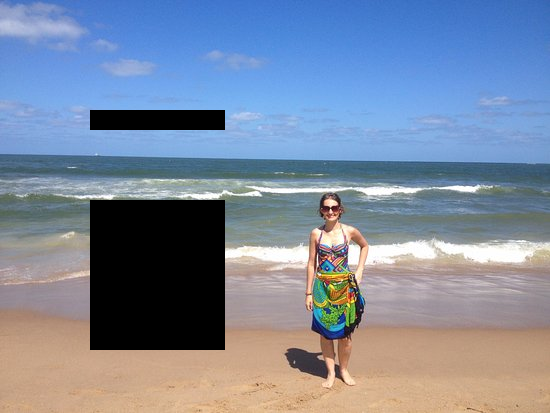

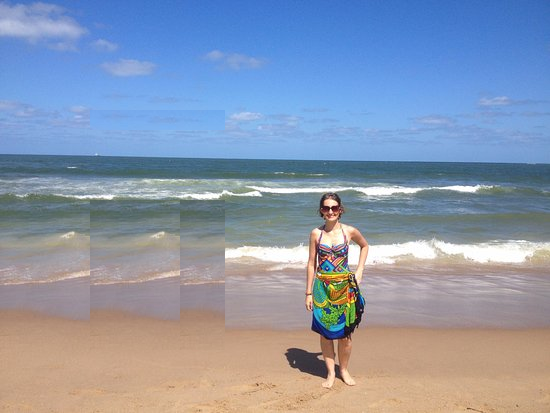

In [29]:
## create inputs for editing 
h_img = cv2.imread("Input/Images/beach_scene.jpg")
h_img[200:350,90:225, :] = np.zeros(h_img[200:350,90:225, :].shape)
h_img[110:130,90:225, :] = np.zeros(h_img[110:130,90:225, :].shape)
cv2_imshow( h_img)
cv2.imwrite("Input/Editing/beach_scene_blackrectangle.jpg", h_img)

h_img[200:350,      90:(225-45), :] = h_img[200:350,(90-90):(225-135), :]
h_img[200:350,(225-45):225,      :] = h_img[200:350,      0:45,        :]
h_img[110:130,      90:225,      :] = h_img[90:110,     90:225,       :]

cv2.imwrite("Input/Editing/beach_scene_translating.jpg", h_img)
cv2_imshow(h_img)